In [1]:
import os
from scipy.linalg import svd 
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import pytest
import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.core.util.exceptions as idaes_except
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
import soec_standalone_flowsheet
from soec_flowsheet_costing import (
    get_solo_soec_capital_costing,
    initialize_flowsheet_costing,
    scale_flowsheet_costing,
    get_soec_OM_costing,
    display_soec_costing
)
import idaes.core.util.model_statistics as mstat
from idaes.models.properties import iapws95
from pyomo.util.check_units import assert_units_consistent
import idaes.core.util as iutil

import numpy as np
import pandas as pd

In [2]:
from pyomo.core.expr.current import identify_variables
from pyomo.common.collections import ComponentSet
def find_active_constraints_containing_variable(var, blk):
    con_set = ComponentSet()
    CUID = pyo.ComponentUID(var)
    for c in blk.component_data_objects(ctype=pyo.Constraint, active=True, descend_into=True):
        for v in identify_variables(c.body):
            if CUID.matches(v):
                con_set.add(c)
    return con_set

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt["options"]["linear_solver"] = "ma57"
idaes.cfg.ipopt["options"]["max_iter"] = 300
idaes.cfg.ipopt["options"]["halt_on_ampl_error"] = "no"

In [4]:
m = pyo.ConcreteModel()
m.fs = soec_standalone_flowsheet.SoecStandaloneFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)

2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 13:09:17 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flas

In [5]:
m.fs.initialize_build(outlvl=idaeslog.INFO_LOW)#, load_from="soec_standalone_init.json.gz")
# m.fs.initialize_build(outlvl=idaeslog.DEBUG)

WARNING (W1002): Setting Var 'fs.water_evaporator01.hot_side.properties_in[0.0
    ].log_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_evaporator01.hot_side.properties_out[0.
    0].log_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_preheater.hot_side.properties_in[0.0].l
    og_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value `4.403681862637669e-10`
    outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_preheater.hot_side.properties_out[0.0].
    log_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also h

In [6]:
print(dof(m))
get_solo_soec_capital_costing(m.fs, CE_index_year="2018")
get_soec_OM_costing(m.fs)
print(dof(m))
iscale.calculate_scaling_factors(m)

0
0
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 13:10:37 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_

In [7]:
solver = pyo.SolverFactory("ipopt")

In [8]:
initialize_flowsheet_costing(m.fs)
scale_flowsheet_costing(m.fs)

m.fs.tags_output["annual_water_cost"] = iutil.ModelTag(
    doc="Annual water cost",
    expr=m.fs.costing.annual_water_cost,
    format_string="{:.2f}",
)

In [9]:
assert dof(m) == 0
solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 300, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=300
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpbbkovoq__ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpbbkovoq__ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2498, 'Number of variables': 2498, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 2.9871833324432373}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
def set_indexed_variable_bounds(var,bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds
if True:
    m.fs.obj = pyo.Objective(
        expr = 10 * (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.total_annualized_cost
            + m.fs.costing.annual_fixed_operations_and_maintenance_cost
            + m.fs.costing.annual_air_cost
        )
    )
    
    m.fs.max_raw_water_withdrawal_eqn.deactivate()
    m.fs.feed_heater.max_heat_duty_eqn.deactivate()
    m.fs.sweep_heater.max_heat_duty_eqn.deactivate()
    m.fs.heat_pump.max_heat_duty_eqn.deactivate()
    
    m.fs.max_raw_water_withdrawal_ineq.activate()
    m.fs.feed_heater.max_heat_duty_ineq.activate()
    m.fs.sweep_heater.max_heat_duty_ineq.activate()
    m.fs.heat_pump.max_heat_duty_ineq.activate()
    
    for hx in [m.fs.feed_hot_exchanger, m.fs.sweep_hot_exchanger, m.fs.sweep_medium_exchanger,
              m.fs.water_evaporator01, m.fs.water_evaporator02, m.fs.water_evaporator03,
              m.fs.water_evaporator04, m.fs.water_evaporator05, m.fs.water_preheater]:
        set_indexed_variable_bounds(hx.delta_temperature_in, (0, None))
        set_indexed_variable_bounds(hx.delta_temperature_out, (0, None))
        hx.area.bounds = (400, None)
        hx.area.unfix()
    
    # I suspect there are several solutions close in price with areas portioned
    # differerently between evaporators. Fix these areas to (hopefully) force
    # IPOPT to just choose one
    m.fs.water_evaporator01.area.fix()
    m.fs.water_evaporator04.area.fix()
    
    @m.fs.Constraint(m.fs.time)
    def water_evaporator02_vapor_out_ineq(b,t):
        try:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Vap","Liq"]
        except KeyError:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Liq","Vap"]
        return (
            b.water_evaporator02.shell.properties_out[t].temperature 
            >= tdew
        )
    iscale.constraint_scaling_transform(m.fs.water_evaporator02_vapor_out_ineq[0], 1e-2)
    
    
    for cmp in [m.fs.sweep_blower, m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        set_indexed_variable_bounds(cmp.work_mechanical, (0, None))
    set_indexed_variable_bounds(m.fs.water_compressor.control_volume.work, (0, None))
    
    m.fs.h2_mass_production.fix(2)
    m.fs.water_preheater.tube_inlet.flow_mol.unfix()
    m.fs.soec_single_pass_water_conversion.unfix()
    m.fs.feed_recycle_split.split_fraction.unfix()
    m.fs.sweep_recycle_split.split_fraction.unfix()
    m.fs.sweep_blower.inlet.flow_mol.unfix()
    #m.fs.sweep_blower.control_volume.properties_out[:].pressure.unfix()
    m.fs.feed_heater.outlet.temperature.unfix()
    m.fs.sweep_heater.outlet.temperature.unfix()
    
    
    
    m.fs.soec_module.potential_cell.unfix()
    m.fs.soec_module.number_cells.unfix()
    m.fs.costing.electricity_price.fix(71.7)
    
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.potential, (1.1,1.6))
    set_indexed_variable_bounds(m.fs.water_split.split_fraction, (0.03,0.98))
    set_indexed_variable_bounds(m.fs.feed_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.sweep_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.heat_pump_hot_terminus.heat_duty, (0, None))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol,(1000,None))
    m.fs.feed_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    m.fs.sweep_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    set_indexed_variable_bounds(m.fs.soec_overall_water_conversion, (0.4,0.8))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.temperature_z, (550+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.oxygen_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-10400,5200))
    set_indexed_variable_bounds(m.fs.heat_source.inlet.flow_mol[0], (1, None))
    
    m.fs.feed_heater.max_heat_duty.set_value(8e6)
    m.fs.sweep_heater.max_heat_duty.set_value(8e6)
    m.fs.feed_heater.max_heat_duty.bounds = (8e6, None)
    m.fs.sweep_heater.max_heat_duty.bounds = (8e6, None)
    #m.fs.heat_pump.max_heat_duty.fix(2e7)
    m.fs.max_raw_water_withdrawal.fix(3000)
    
    for cmp in [m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        cmp.ratioP.unfix()
        set_indexed_variable_bounds(cmp.ratioP, (1, 3))
        set_indexed_variable_bounds(cmp.outlet.temperature, (273.15, 250+273.15))
    
    m.fs._make_temperature_gradient_terms()
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_electrode.dtemperature_dz, (-750, 750))
    m.fs.make_performance_constraints()
#     @m.fs.Constraint(m.fs.time)
#     def equal_pressures_eqn(b,t):
#        return b.soec_module.fuel_inlet.pressure[t] == b.soec_module.oxygen_inlet.pressure[t]
    
#     iscale.constraint_scaling_transform(m.fs.equal_pressures_eqn[0],1e-5)

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1634)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1637)


In [11]:
m.fs.h2_mass_production.fix(5)
jac_unscaled, jac_scaled, nlp = iscale.constraint_autoscale_large_jac(m)
solver.solve(m, tee=True, options={"tol": 3e-8, "max_iter": 500, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=3e-08
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpse1uf2mn_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpse1uf2mn_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

  67  5.4673312e+03 1.78e-12 1.14e+00  -5.7 6.10e-08   7.3 1.00e+00 1.00e+00h  1
  68  5.4673312e+03 1.32e-12 1.14e+00  -5.7 1.83e-07   6.8 1.00e+00 1.00e+00h  1
  69  5.4673312e+03 1.87e-12 1.14e+00  -5.7 5.50e-07   6.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.4673312e+03 9.84e-13 1.14e+00  -5.7 1.65e-06   5.8 1.00e+00 1.00e+00h  1
  71  5.4673312e+03 1.01e-12 1.14e+00  -5.7 4.95e-06   5.4 1.00e+00 1.00e+00f  1
  72  5.4673312e+03 1.42e-12 1.14e+00  -5.7 1.48e-05   4.9 1.00e+00 1.00e+00f  1
  73  5.4673310e+03 1.27e-11 1.14e+00  -5.7 4.45e-05   4.4 1.00e+00 1.00e+00f  1
  74  5.4673306e+03 1.15e-10 1.14e+00  -5.7 1.34e-04   3.9 1.00e+00 1.00e+00f  1
  75  5.4673292e+03 1.03e-09 1.14e+00  -5.7 4.01e-04   3.5 1.00e+00 1.00e+00f  1
  76  5.4673250e+03 9.29e-09 1.14e+00  -5.7 1.20e-03   3.0 1.00e+00 1.00e+00f  1
  77  5.4673125e+03 8.37e-08 1.14e+00  -5.7 3.61e-03   2.5 1.00e+00 1.00e+00f  1
  78  5.4672750e+03 7.53e-07

 161  5.3214885e+03 4.78e-01 2.10e+07  -5.7 1.25e+01   1.2 9.42e-04 9.42e-04s 12
 162  5.3214889e+03 4.78e-01 2.09e+07  -5.7 6.02e+01   0.7 2.93e-04 2.93e-04s 12
 163  5.3214890e+03 4.78e-01 2.09e+07  -5.7 1.43e+01   1.1 2.83e-04 2.83e-04s 12
 164r 5.3214890e+03 4.78e-01 1.00e+03  -0.3 0.00e+00   0.6 0.00e+00 0.00e+00R  1
 165r 5.3252593e+03 4.86e-01 1.15e+03  -0.3 1.01e+05    -  8.59e-06 2.75e-04f  1
 166r 5.3251505e+03 4.21e-01 2.54e+04  -0.3 1.92e+02   0.0 1.68e-02 1.99e-03f  1
 167r 5.3256198e+03 4.16e-01 2.51e+04  -0.3 2.49e+01    -  5.59e-03 9.96e-03f  1
 168r 5.3266061e+03 4.07e-01 2.45e+04  -0.3 2.27e+01    -  2.25e-02 2.29e-02f  1
 169r 5.3289163e+03 3.78e-01 2.10e+04  -0.3 1.91e+01    -  1.75e-01 7.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 5.3378357e+03 2.60e-01 3.13e+04  -0.3 5.84e+01    -  2.11e-01 3.51e-01f  1
 171r 5.3526060e+03 4.66e-02 2.31e+04  -0.3 1.24e+01    -  3.75e-01 1.00e+00f  1
 172r 5.3672961e+03 2.48e-01

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2534, 'Number of variables': 2534, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 53.46643614768982}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
m.fs.soec_module.number_cells.pprint()
m.fs.soec_module.solid_oxide_cell.current_density.pprint()
print(pyo.value(m.fs.soec_module.solid_oxide_cell.average_current_density[0]))
print(pyo.value((m.fs.obj)*1e5/(5*m.fs.costing.plant_uptime)))

number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2959059705 :  None : False : False :  Reals
current_density : Size=10, Index=fs.soec_module.solid_oxide_cell.current_density_index, Units=A/m**2
    Key       : Lower  : Value               : Upper : Fixed : Stale : Domain
     (0.0, 1) : -10400 :    -8552.4811029625 :  5200 : False : False :  Reals
     (0.0, 2) : -10400 :  -9872.858865665896 :  5200 : False : False :  Reals
     (0.0, 3) : -10400 :            -10400.0 :  5200 : False : False :  Reals
     (0.0, 4) : -10400 : -10146.127669425066 :  5200 : False : False :  Reals
     (0.0, 5) : -10400 :  -9367.403147507213 :  5200 : False : False :  Reals
     (0.0, 6) : -10400 :  -8331.578729898854 :  5200 : False : False :  Reals
     (0.0, 7) : -10400 :  -7240.200662162375 :  5200 : False : False :  Reals
     (0.0, 8) : -10400 :  -6214.108854140629 :  5200 : False : Fa

In [13]:
display_soec_costing(m.fs)

Capital cost: $439M
Fixed O&M cost: $26.1M/yr
Electricity cost: $2.87/kg H2
Water cost: $0.01/kg H2
Air cost: $0.07/kg H2


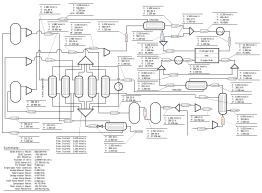

In [14]:
display(SVG(m.fs.write_pfd()))

In [15]:
streams_df = m.fs.streams_dataframe()
display(streams_df)

,mass flow (kg/s),mole flow (kmol/s),mole percent Ar (%),mole percent CO2 (%),mole percent H2 (%),mole percent H2O (%),mole percent N2 (%),mole percent O2 (%),pressure (bar),temperature (K),vapor fraction (%),volumetric flow (m**3/s)
feed01,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,489.184396,100.0,104.510707
feed02a,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,837.804026,100.0,179.843508
feed02b,55.850942,3.100198,NaN,NaN,0.0,100.0,NaN,NaN,1.2,837.804026,NaN,179.816147
feed03,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,893.356797,NaN,383.734354
feed04,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,929.128108,NaN,399.115452
hstrm01,32.33988,6.200397,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,413.414799
hstrm02,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707404
hstrm03,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707395
hstrm04,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,546.975234,NaN,117.492387
hstrm05,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,372.220932,NaN,79.914997


In [16]:
m.fs.write_pfd(fname="soec_standalone_design_point.svg")
streams_df.to_csv("soec_standalone_design_point.csv")

In [17]:
water_heaters = [
    m.fs.water_evaporator01,
    m.fs.water_evaporator02,
    m.fs.water_evaporator03,
    m.fs.water_evaporator04,
    m.fs.water_evaporator05,
    m.fs.water_preheater,
]
cross_flow_exchangers = [
    m.fs.feed_hot_exchanger,
    m.fs.sweep_hot_exchanger,
    m.fs.sweep_medium_exchanger,
]
heaters = [
    m.fs.feed_heater,
    m.fs.sweep_heater
]
flash_vessels = [m.fs.product_flash01,
                 m.fs.product_flash02,
                 m.fs.product_flash03, m.fs.product_flash04]



compressors = [getattr(m.fs, f"cmp0{i}") for i in range(1,5)]
print(f"Total CapEx: ${pyo.value(m.fs.costing.total_TPC):.2f}MM")
print(f"Contribution from SOEC: ${pyo.value(m.fs.soec_module.costing.total_plant_cost):.2f}MM")
print(f"Contribution from H2 compressors: ${pyo.value(sum([cmp.costing.total_plant_cost for cmp in compressors])):.2f}MM")
print(f"Contribution from H2O compressor: ${pyo.value(m.fs.water_compressor.costing.total_plant_cost):.2f}MM")
print(f"Contribution from trim heaters: ${pyo.value(sum([heater.costing.total_plant_cost for heater in heaters])):.2f}MM")
print(f"Contribution from gas-gas exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in cross_flow_exchangers])):.2f}MM")
print(f"Contribution from gas-water exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in water_heaters])):.2f}MM")
print(f"Contribution from flash vessels: ${pyo.value(sum([flash.costing.total_plant_cost for flash in flash_vessels])):.2f}MM")
print(f"Contribution from heat pump: ${pyo.value(m.fs.heat_pump.costing.total_plant_cost):.2f}MM")
print(f"Contribution from sweep blower: ${pyo.value(m.fs.sweep_blower.costing.total_plant_cost):.2f}MM")
print(f"Contribution from water feed & treatment systems: ${pyo.value(m.fs.costing.water_systems_cost):.2f}MM")
print(f"Contribution from accessory electric equipment: ${pyo.value(m.fs.costing.accessory_electric_plant_cost):.2f}MM")
print(f"Contribution from instrumentation and controls: ${pyo.value(m.fs.costing.instrumentation_and_control_cost):.2f}MM")
print(f"Contribution from improvements to site: ${pyo.value(m.fs.costing.improvements_to_site_cost):.2f}MM")
print(f"Contribution from buildings and structures: ${pyo.value(m.fs.costing.buildings_and_structures_cost):.2f}MM")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

# tpc = pyo.value(m.fs.costing.total_TPC)
# tasc = tpc*1.21*1.093
# ac = tasc*0.0707
assert pyo.value(m.fs.costing.total_TPC) == pytest.approx(439.5608, rel=1e-3)
print(f"TPC = {pyo.value(m.fs.costing.total_TPC)}")
print(f"TASC = {pyo.value(m.fs.costing.total_as_spent_cost)}")
assert pyo.value(m.fs.costing.total_annualized_cost) == pytest.approx(41.100, rel=1e-3)
print(f"Annualized TASC (MM$/yr) = {pyo.value(m.fs.costing.total_annualized_cost)}")

# Parameters
# n_op = 6.3
# hourly_rate = 38.50
# labor_burden = 30

# Fixed O&M components
# annual_op_labor = n_op * hourly_rate * 8760 * (1 - labor_burden/100)/1e6
# maint_labor = tpc * 0.4 * 0.019 
# maint_material = tpc * 0.6 * 0.019
# admin_labor = 0.25*(annual_op_labor + maint_labor)
# prop_tax_ins = 0.02*tpc
# soec_replace = pyo.value(4.2765*m.fs.soec_module.number_cells)/1e6

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {pyo.value(m.fs.costing.annual_operating_labor_cost)}")
print(f"maint_labor (MM$/yr) = {pyo.value(m.fs.costing.maintenance_labor_cost)}")
print(f"maint_material (MM$/yr) = {pyo.value(m.fs.costing.maintenance_material_cost)}")
print(f"admin_labor (MM$/yr) = {pyo.value(m.fs.costing.admin_and_support_labor_cost)}")
print(f"prop_tax_ins (MM$/yr) = {pyo.value(m.fs.costing.property_tax_and_insurance_cost)}")
print(f"soec_replace (MM$/yr) = {pyo.value(m.fs.soec_module.costing.annual_soec_replacement_cost)}")
# total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M (MM$/year) = {pyo.value(m.fs.costing.annual_fixed_operations_and_maintenance_cost)}")
fixed_cost_per_h2 = pyo.value(
    m.fs.costing.total_annualized_cost
    + m.fs.costing.annual_fixed_operations_and_maintenance_cost
)/24/365.2425/5/60/60*1e6
print(f"Fixed ($/kg h2) = {fixed_cost_per_h2}")

print(f"Annual water cost MM$ {pyo.value(m.fs.costing.annual_water_cost)}")
print(f"water cost $/kg h2 {pyo.value(m.fs.costing.annual_water_cost)/24/365/5/60/60*1e6}")

Total CapEx: $439.37MM
Contribution from SOEC: $72.84MM
Contribution from H2 compressors: $25.80MM
Contribution from H2O compressor: $45.96MM
Contribution from trim heaters: $25.18MM
Contribution from gas-gas exchangers: $16.46MM
Contribution from gas-water exchangers: $32.87MM
Contribution from flash vessels: $0.45MM
Contribution from heat pump: $34.77MM
Contribution from sweep blower: $2.88MM
Contribution from water feed & treatment systems: $31.12MM
Contribution from accessory electric equipment: $93.02MM
Contribution from instrumentation and controls: $23.19MM
Contribution from improvements to site: $27.48MM
Contribution from buildings and structures: $7.34MM


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 439.3733018817972
TASC = 581.0843729377332
Annualized TASC (MM$/yr) = 41.08266516669774
Fixed O&M Costs
annual_op_labor (MM$/yr) = 2.7639945332999996
maint_labor (MM$/yr) = 3.3392370943016587
maint_mat

In [18]:
assert m.fs.tags_output['total_electric_power_per_h2'].value == pytest.approx(143.998, rel=1e-3)
assert m.fs.tags_input['water_utilization'].value == pytest.approx(66.667, rel=1e-3)

In [20]:
print(m.fs.tags_output['total_electric_power_per_h2'].value)
print(m.fs.tags_input['water_utilization'].value)
m.fs.soec_module.number_cells.pprint()

143.95132766227835
66.66666761317471
number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2959059705 :  None : False : False :  Reals


In [21]:
for hx in water_heaters + cross_flow_exchangers:
    print(f"{hx.name}: {pyo.value(hx.area)}")

fs.water_evaporator01: 2018
fs.water_evaporator02: 1632.3427750136957
fs.water_evaporator03: 1513.6511305386487
fs.water_evaporator04: 5245
fs.water_evaporator05: 5267.211672692907
fs.water_preheater: 1746.3021522482152
fs.feed_hot_exchanger: 4639.917457701005
fs.sweep_hot_exchanger: 5522.233880831356
fs.sweep_medium_exchanger: 8511.830382240101


In [24]:
for flash in flash_vessels:
    flash.diameter.fix()
    flash.length.fix()
    flash.length_diameter_heuristic.deactivate()
    flash.capacity_heuristic.deactivate()

for hx in water_heaters + cross_flow_exchangers:
    hx.area.fix()

for heater in heaters:
    heater.max_heat_duty.fix()
    
for blk in m.fs.block_data_objects():
    if hasattr(blk, "costing"):
        blk.costing.deactivate()

# Need the parent costing block for variable cost
m.fs.costing.activate()
m.fs.costing.total_TPC.fix()
m.fs.costing.total_TPC_eqn.deactivate()
    
m.fs.soec_module.number_cells.fix()
m.fs.max_raw_water_withdrawal.fix()
m.fs.heat_pump.max_heat_duty.fix()

m.fs.obj.deactivate()
m.fs.obj2 = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )  

In [25]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)


if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 500, "halt_on_ampl_error":"no"})
        assert res.solver.termination_condition == pyo.TerminationCondition.optimal
        assert res.solver.status == pyo.SolverStatus.ok
        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1


5.0
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp7wsjy1d6_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp7wsjy1d6_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

  73  4.6498807e+02 1.86e-06 4.43e+05  -1.7 5.79e+01    -  9.90e-01 5.21e-03f  8
  74  4.6498808e+02 1.86e-06 6.69e+05  -1.7 6.79e+01    -  9.90e-01 2.98e-03h  9
  75  4.6498808e+02 1.93e-06 8.85e+05  -1.7 3.53e+01    -  9.90e-01 1.26e-02h  7
  76  4.6498810e+02 2.09e-06 1.09e+06  -1.7 1.86e+01    -  9.94e-01 2.58e-02h  6
  77  4.6498859e+02 2.16e-06 2.15e+05  -1.7 1.04e+01    -  1.00e+00 8.38e-01H  1
  78  4.6498861e+02 1.50e-06 1.39e+06  -1.7 3.34e+01    -  8.64e-01 6.29e-02h  4
  79  4.6498861e+02 1.44e-06 2.92e+06  -1.7 3.09e+01    -  1.00e+00 1.70e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.6498861e+02 1.38e-06 4.44e+06  -1.7 3.07e+01    -  1.00e+00 1.72e-02h  6
  81  4.6498862e+02 1.32e-06 5.97e+06  -1.7 3.05e+01    -  1.00e+00 1.73e-02h  6
  82  4.6498862e+02 1.26e-06 7.50e+06  -1.7 3.05e+01    -  1.00e+00 1.72e-02h  6
  83  4.6498862e+02 1.33e-06 9.03e+06  -1.7 3.06e+01    -  1.00e+00 1.71e-02h  6
  84  4.6498863e+02 1.46e-06

 166  4.6498879e+02 2.54e-04 5.60e+15  -1.7 5.11e+01    -  1.00e+00 3.71e-01w  1
 167  4.6498881e+02 2.48e-04 1.24e+17  -1.7 5.48e+01    -  1.00e+00 6.99e-02w  1
 168  4.6498884e+02 2.42e-04 5.67e+17  -1.7 3.79e+01    -  1.00e+00 1.90e-01w  1
 169  4.6498871e+02 3.02e-06 2.87e+15  -1.7 8.84e+01    -  1.00e+00 1.45e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.6498871e+02 3.02e-06 2.87e+15  -1.7 5.11e+01    -  1.00e+00 1.45e-03h  9
 171  4.6498871e+02 3.02e-06 2.87e+15  -1.7 5.13e+01    -  1.00e+00 1.45e-03h  9
 172  4.6498871e+02 3.02e-06 2.88e+15  -1.7 5.14e+01    -  1.00e+00 1.45e-03h  9
 173  4.6498871e+02 3.01e-06 2.88e+15  -1.7 5.15e+01    -  1.00e+00 1.45e-03h  9
 174  4.6498871e+02 3.01e-06 2.88e+15  -1.7 5.16e+01    -  1.00e+00 1.45e-03h  9
 175  4.6498872e+02 3.01e-06 2.88e+15  -1.7 5.17e+01    -  1.00e+00 1.45e-03h  9
 176  4.6498872e+02 3.01e-06 2.88e+15  -1.7 5.18e+01    -  1.00e+00 1.45e-03h  9
 177  4.6498872e+02 3.01e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  4.6498874e+02 3.03e-06 3.00e+15  -1.7 1.40e-02  15.8 1.00e+00 1.44e-03h  8
 261  4.6498874e+02 3.03e-06 3.00e+15  -1.7 5.83e+01    -  1.00e+00 1.44e-03h  9
 262  4.6498874e+02 3.03e-06 3.01e+15  -1.7 5.84e+01    -  1.00e+00 1.44e-03h  9
 263  4.6498874e+02 3.03e-06 3.01e+15  -1.7 5.85e+01    -  1.00e+00 1.44e-03h  9
 264  4.6498874e+02 3.03e-06 3.01e+15  -1.7 5.86e+01    -  1.00e+00 1.44e-03h  9
 265  4.6498874e+02 3.03e-06 3.02e+15  -1.7 5.87e+01    -  1.00e+00 1.44e-03h  9
 266  4.6498874e+02 3.03e-06 3.02e+15  -1.7 5.88e+01    -  1.00e+00 1.44e-03h  9
 267  4.6498874e+02 3.03e-06 3.02e+15  -1.7 5.89e+01    -  1.00e+00 1.44e-03h  9
 268  4.6498874e+02 3.03e-06 3.02e+15  -1.7 5.90e+01    -  1.00e+00 1.44e-03h  9
 269  4.6498874e+02 3.03e-06 3.03e+15  -1.7 5.91e+01    -  1.00e+00 1.44e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  4.6498883e+02 3.56e-04

 352  4.6498875e+02 3.05e-06 3.18e+15  -1.7 6.33e+01    -  1.00e+00 7.36e-04h 10
 353  4.6498875e+02 3.05e-06 3.18e+15  -1.7 6.33e+01    -  1.00e+00 7.37e-04h 10
 354  4.6498876e+02 3.05e-06 3.19e+15  -1.7 6.34e+01    -  1.00e+00 7.37e-04h 10
 355  4.6498876e+02 3.05e-06 3.19e+15  -1.7 6.34e+01    -  1.00e+00 7.37e-04h 10
 356  4.6498876e+02 3.05e-06 3.19e+15  -1.7 6.35e+01    -  1.00e+00 7.37e-04h 10
 357  4.6498876e+02 3.05e-06 3.19e+15  -1.7 6.35e+01    -  1.00e+00 7.38e-04h 10
 358  4.6498876e+02 3.05e-06 3.19e+15  -1.7 6.35e+01    -  1.00e+00 7.38e-04h 10
 359  4.6498876e+02 3.05e-06 3.20e+15  -1.7 6.36e+01    -  1.00e+00 7.38e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  4.6498876e+02 3.05e-06 3.20e+15  -1.7 6.36e+01    -  1.00e+00 7.39e-04h 10
 361  4.6498885e+02 4.51e-04 8.00e+15  -1.7 6.37e+01    -  1.00e+00 3.78e-01w  1
 362  4.6498901e+02 1.89e-03 4.06e+15  -1.7 9.18e+01    -  4.68e-01 4.76e-01w  1
 363  4.6498895e+02 2.10e-03

 445  4.6498928e+02 1.56e-04 6.72e+11  -1.7 1.26e+01    -  2.30e-03 1.26e-03h  1
 446  4.6498928e+02 1.56e-04 2.17e+15  -1.7 1.29e+01    -  2.55e-02 1.27e-05h  1
 447r 4.6498928e+02 1.56e-04 1.00e+03  -1.7 0.00e+00    -  0.00e+00 6.42e-08R  2
 448r 4.6499063e+02 3.51e-05 1.44e+03  -1.7 7.13e-01    -  1.63e-01 1.35e-01f  1
 449  4.6499064e+02 3.51e-05 3.01e+02  -1.7 1.96e+02    -  4.83e-03 3.08e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  4.6499058e+02 4.37e-05 2.99e+02  -1.7 4.91e+02    -  1.08e-03 5.86e-03f  1
 451  4.6499057e+02 4.33e-05 9.60e+02  -1.7 1.16e+02    -  7.29e-02 9.06e-03f  1
 452  4.6499036e+02 5.58e-05 2.99e+03  -1.7 8.36e+01    -  1.93e-01 6.34e-02f  2
 453  4.6498944e+02 5.07e-05 4.19e+03  -1.7 2.99e+01    -  2.30e-01 5.19e-01H  1
 454  4.6498944e+02 5.03e-05 1.13e+05  -1.7 9.96e+00    -  9.70e-01 6.87e-03f  5
 455  4.6498947e+02 5.09e-05 3.24e+05  -1.7 4.55e+01    -  9.90e-01 7.71e-02h  3
 456  4.6498950e+02 5.34e-05

AssertionError: 

In [28]:
m.fs.obj2 = pyo.Objective(
        expr = 0.1*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )  

    'pyomo.core.base.objective.ScalarObjective'>) on block fs with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [29]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)

if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 500, "halt_on_ampl_error":"no"})
        assert res.solver.termination_condition == pyo.TerminationCondition.optimal
        assert res.solver.status == pyo.SolverStatus.ok
        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1

5.0
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpo00o6ho8_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpo00o6ho8_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

  66  4.6498896e+01 4.00e-05 6.46e+05  -1.0 1.75e+02    -  5.83e-01 1.42e-02h  7
  67  4.6498895e+01 4.00e-05 7.07e+05  -1.0 1.55e+02    -  9.63e-01 7.23e-03h  8
  68  4.6498896e+01 3.95e-05 7.41e+05  -1.0 1.61e+02    -  6.45e-01 1.43e-02h  7
  69  4.6498894e+01 4.01e-05 8.01e+05  -1.0 1.43e+02    -  1.00e+00 1.45e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.6498938e+01 1.52e-03 5.12e+04  -1.0 1.45e+02    -  7.85e-01 9.24e-01w  1
  71  4.6498906e+01 1.37e-03 2.85e+04  -1.0 1.22e+02    -  7.43e-01 7.84e-01w  1
  72  4.6498888e+01 2.31e-03 7.85e+05  -1.0 1.23e+02    -  2.34e-01 4.09e-01w  1
  73  4.6498895e+01 3.99e-05 8.45e+05  -1.0 1.02e+02    -  7.85e-01 1.44e-02h  6
  74  4.6498894e+01 4.04e-05 9.04e+05  -1.0 1.29e+02    -  1.00e+00 1.46e-02h  7
  75  4.6498894e+01 4.07e-05 9.64e+05  -1.0 1.27e+02    -  1.00e+00 1.46e-02h  7
  76  4.6498893e+01 4.12e-05 1.02e+06  -1.0 1.12e+02    -  1.00e+00 1.47e-02h  7
  77  4.6498893e+01 4.18e-05

 159  4.6498889e+01 4.16e-05 1.01e+14  -1.0 5.24e+01    -  1.00e+00 1.95e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.6498890e+01 4.15e-05 1.60e+14  -1.0 5.18e+01    -  1.00e+00 1.96e-02h  6
 161  4.6498890e+01 4.13e-05 2.51e+14  -1.0 5.12e+01    -  1.00e+00 1.97e-02h  6
 162  4.6498890e+01 4.12e-05 3.93e+14  -1.0 5.09e+01    -  1.00e+00 1.98e-02h  6
 163  4.6498894e+01 7.03e-04 2.26e+14  -1.0 5.09e+01    -  1.00e+00 6.36e-01w  1
 164  4.6498908e+01 4.68e-03 1.44e+15  -1.0 7.92e+01    -  2.90e-01 9.38e-01w  1
 165  4.6498919e+01 3.56e-03 1.04e+15  -1.0 3.04e+01    -  1.15e-01 2.87e-01w  1
 166  4.6498890e+01 4.10e-05 6.11e+14  -1.0 5.12e+00    -  1.00e+00 1.99e-02h  5
 167  4.6498890e+01 4.09e-05 9.42e+14  -1.0 5.12e+01    -  1.00e+00 2.00e-02h  6
 168  4.6498890e+01 4.08e-05 1.44e+15  -1.0 5.19e+01    -  1.00e+00 2.02e-02h  6
 169  4.6498890e+01 4.07e-05 2.19e+15  -1.0 5.27e+01    -  1.00e+00 2.04e-02h  6
iter    objective    inf_pr 

 251  4.6498896e+01 3.75e-05 4.53e+15  -1.0 8.21e+01    -  1.00e+00 3.76e-03h  9
 252  4.6498896e+01 3.74e-05 4.59e+15  -1.0 8.15e+01    -  1.00e+00 3.78e-03h  9
 253  4.6498896e+01 3.74e-05 4.69e+15  -1.0 8.09e+01    -  1.00e+00 3.79e-03h  9
 254  4.6498915e+01 5.39e-03 1.65e+14  -1.0 8.11e+01    -  1.00e+00 9.66e-01w  1
 255  4.6498916e+01 5.35e-03 1.36e+15  -1.0 6.72e+01    -  8.49e-02 6.16e-03w  1
 256  4.6498917e+01 5.33e-03 1.86e+15  -1.0 1.59e+02    -  3.96e-02 5.40e-03w  1
 257  4.6498896e+01 3.73e-05 4.89e+15  -1.0 3.45e+01    -  1.00e+00 3.78e-03h  8
 258  4.6498897e+01 3.73e-05 4.83e+15  -1.0 7.99e+01    -  1.00e+00 7.64e-03h  8
 259  4.6498897e+01 3.73e-05 5.61e+15  -1.0 8.59e+01    -  7.04e-01 5.86e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  4.6498897e+01 3.73e-05 3.84e+15  -1.0 7.18e+01    -  1.00e+00 5.42e-03h  8
 261  4.6498897e+01 3.73e-05 4.28e+15  -1.0 1.74e+02    -  2.67e-02 1.36e-03h  8
 262  4.6498897e+01 3.73e-05

 344  4.6498882e+01 3.22e-06 5.10e+07  -1.0 4.62e+01    -  1.00e+00 1.79e-03h 10
 345  4.6498882e+01 3.22e-06 5.22e+07  -1.0 4.61e+01    -  1.00e+00 1.79e-03h 10
 346  4.6498882e+01 3.22e-06 5.33e+07  -1.0 4.60e+01    -  1.00e+00 1.79e-03h 10
 347  4.6498882e+01 3.22e-06 5.44e+07  -1.0 4.59e+01    -  1.00e+00 1.79e-03h 10
 348  4.6498882e+01 3.22e-06 5.55e+07  -1.0 4.58e+01    -  1.00e+00 1.79e-03h 10
 349  4.6498884e+01 1.76e-03 1.57e+07  -1.0 4.57e+01    -  1.00e+00 9.14e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  4.6498885e+01 1.54e-03 1.48e+08  -1.0 9.72e+00    -  1.00e+00 1.27e-01w  1
 351  4.6498885e+01 1.53e-03 4.12e+10  -1.0 5.42e+00    -  1.00e+00 4.62e-03w  1
 352  4.6498882e+01 3.22e-06 5.66e+07  -1.0 3.71e-01    -  1.00e+00 1.79e-03h  9
 353  4.6498882e+01 3.22e-06 5.78e+07  -1.0 4.56e+01    -  1.00e+00 1.79e-03h 10
 354  4.6498882e+01 3.22e-06 5.89e+07  -1.0 4.56e+01    -  1.00e+00 1.79e-03h 10
 355  4.6498882e+01 3.22e-06

 437  4.6498883e+01 3.67e-06 7.71e+09  -1.0 3.69e+01    -  1.00e+00 3.51e-03h  9
 438  4.6498883e+01 3.68e-06 8.49e+09  -1.0 3.67e+01    -  1.00e+00 3.51e-03h  9
 439  4.6498883e+01 3.68e-06 9.35e+09  -1.0 3.66e+01    -  1.00e+00 3.51e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  4.6498889e+01 1.22e-03 6.23e+09  -1.0 3.65e+01    -  1.00e+00 8.99e-01w  1
 441  4.6498889e+01 1.09e-03 8.19e+10  -1.0 1.09e+01    -  1.00e+00 1.05e-01w  1
 442  4.6498889e+01 1.09e-03 2.38e+13  -1.0 3.80e+00    -  1.00e+00 4.18e-03w  1
 443  4.6498883e+01 3.69e-06 1.03e+10  -1.0 1.68e+02    -  1.00e+00 3.51e-03h  8
 444  4.6498883e+01 3.69e-06 1.14e+10  -1.0 3.63e+01    -  1.00e+00 3.51e-03h  9
 445  4.6498883e+01 3.70e-06 1.25e+10  -1.0 3.62e+01    -  1.00e+00 3.51e-03h  9
 446  4.6498883e+01 3.70e-06 1.38e+10  -1.0 3.61e+01    -  1.00e+00 3.51e-03h  9
 447  4.6498883e+01 3.71e-06 1.52e+10  -1.0 3.59e+01    -  1.00e+00 3.51e-03h  9
 448  4.6498883e+01 3.71e-06

AssertionError: 

In [ ]:
if df is not None:
    df.to_csv("soec.csv")

In [ ]:
display(SVG(m.fs.write_pfd()))

In [ ]:
for flash in [m.fs.product_flash01, 
              #m.fs.product_flash02,
              m.fs.product_flash03, m.fs.product_flash04]:
    print(flash.name)
    print(f"Diameter: {flash.diameter.value}m")
    print(f"Height: {flash.length.value}m")
    print()

In [ ]:
print(df)

In [26]:
from idaes.core.util.model_diagnostics import DegeneracyHunter
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)
    # djac = jac.todense()
    # print("Extreme Jacobian entries:")
    # for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1E3, small=0):
    #     print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
    print("Badly scaled variables:")
    for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print("\n\n" + "Badly scaled constraints:")
    for i in iscale.extreme_jacobian_rows(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    #print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

    if not hasattr(blk, "obj"):
        blk.obj = pyo.Objective(expr=0)
    dh = DegeneracyHunter(blk, solver=pyo.SolverFactory('cbc'))
    dh.check_rank_equality_constraints(dense=True)
    variables = nlp.get_pyomo_variables()
    constraints = nlp.get_pyomo_equality_constraints()
    # ds = dh.find_candidate_equations()
    for i in np.where(abs(dh.v[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + variables[i].name)
    for i in np.where(abs(dh.u[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + constraints[i].name)

    return (variables, constraints, jac, dh)

In [32]:
variables, constraints, jac, dh = check_scaling(m.fs)

Badly scaled variables:


Badly scaled constraints:

Checking rank of Jacobian of equality constraints...
Model contains 2401 equality constraints and 2410 variables.
Computing the 10 smallest singular value(s)
Smallest singular value(s):
9.947E-06
1.076E-05
1.193E-05
1.277E-05
1.320E-05
1.653E-05
4.530E-05
9.148E-05
1.275E-04
2.590E-04
150: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,1,H2]
151: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,1,H2O]
152: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,2,H2]
153: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,2,H2O]
154: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,3,H2]
155: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,3,H2O]
156: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,4,H2]
157: fs.soec_module.solid_oxide_cell.fuel_channel.diff_eff_coeff[0.0,4,H2O]
158: fs.soec_module.solid_oxide_cell.fuel_channel.diff_ef

In [ ]:
m.fs.heat_source.report()

In [30]:
dh.check_residuals(1e-6)

 
All constraints with residuals larger than 1e-06 :
Count	Name	|residual|
0 	 fs.sweep_recycle_split.material_splitting_eqn[0.0,recycle,N2] 	 3.835453326246352e-06
1 	 fs.sweep_recycle_split.material_splitting_eqn[0.0,out,N2] 	 3.835418956441572e-06
2 	 fs.sweep_recycle_split.material_splitting_eqn[0.0,recycle,O2] 	 2.1176596283112306e-06
3 	 fs.sweep_recycle_split.material_splitting_eqn[0.0,out,O2] 	 2.117612089023169e-06


dict_keys([<pyomo.core.base.constraint._GeneralConstraintData object at 0x000002AF435FEA40>, <pyomo.core.base.constraint._GeneralConstraintData object at 0x000002AF435FE860>, <pyomo.core.base.constraint._GeneralConstraintData object at 0x000002AF435FE920>, <pyomo.core.base.constraint._GeneralConstraintData object at 0x000002AF435FE740>])

In [33]:
dh.check_variable_bounds(relative=True)

 
Variables within 1e-05 (relative) of their bounds:
variable	lower	value	upper
fs.feed_recycle_mix.feed_state[0.0].mole_frac_comp[H2] 		 1e-20 	 5.454217658964095e-07 	 1.001
fs.feed_recycle_mix.feed_state[0.0].mole_frac_phase_comp[Vap,H2] 		 1e-20 	 5.460331064656993e-07 	 1.001
fs.feed_translator.properties_out[0.0].mole_frac_comp[H2] 		 1e-20 	 5.444774102202248e-07 	 1.001
fs.feed_translator.properties_out[0.0].mole_frac_phase_comp[Vap,H2] 		 1e-20 	 5.448092249724566e-07 	 1.001
fs.feed_heater.max_heat_duty 		 8000000.0 	 8000000.0 	 None
fs.sweep_heater.max_heat_duty 		 8000000.0 	 8000000.0 	 None
fs.product_flash01.control_volume.properties_in[0.0].log_mole_frac_phase_comp[Liq,H2O] 		 -100 	 -1.2166568609399281e-09 	 0.0009995003330834232
fs.product_flash01.control_volume.properties_out[0.0].log_mole_frac_phase_comp[Liq,H2O] 		 -100 	 -2.0111274523055082e-08 	 0.0009995003330834232
fs.cmp01.ratioP[0.0] 		 1 	 2.9999919252809386 	 3
fs.product_flash02.control_volume.properties_

In [ ]:
dir(m.fs)

In [38]:
m.fs.product_flash05.report()


Unit : fs.product_flash05                                                  Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value       : Units  : Fixed : Bounds
          Heat Duty : -7.9422e+06 :   watt : False : (None, None)
    Pressure Change :      0.0000 : pascal :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                Units         Inlet    Vapor Outlet  Liquid Outlet
    Total Molar Flowrate     mole / second     2542.0            -             -  
    Total Mole Fraction H2   dimensionless    0.97568            -             -  
    Total Mole Fraction H2O  dimensionless   0.024322            -             -  
    Temperature                     kelvin     359.56            -             -  
    Pressure                        pascal 2.7279e+06            -             -